# Fantasy Football Player Prediction Model

In [31]:
import pandas as pd

# Load the sample dataset
df = pd.read_csv("yearly_player_stats_offense.csv")


In [8]:
df.head()

,player_id,player_name,position,birth_year,draft_year,draft_round,draft_pick,draft_ovr,height,weight,...,delta_pass_td_pct,delta_ypa,delta_rec_td_pct,delta_yptarget,delta_ayptarget,delta_ypr,delta_rush_td_pct,delta_ypc,delta_td_pct,delta_yptouch
0,00-0000865,Charlie Batch,QB,1974,1998.0,2.0,30.0,60.0,74.0,216.0,...,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,0.000000,-0.909091,-0.388795
1,00-0004541,Donald Driver,WR,1975,1999.0,7.0,7.0,213.0,72.0,194.0,...,0.0,0.0,0.000000,-0.172028,-11.952941,-0.068732,-1.0,-1.000000,49.000000,1.226852
2,00-0006101,Tony Gonzalez,TE,1976,1997.0,1.0,13.0,13.0,77.0,247.0,...,0.0,0.0,0.000000,1.246341,-0.509202,-0.326262,0.0,0.000000,0.000000,-0.326262
3,00-0006101,Tony Gonzalez,TE,1976,1997.0,1.0,13.0,13.0,77.0,247.0,...,0.0,0.0,-0.538462,-0.165038,-0.002500,0.085776,0.0,0.000000,-0.413793,0.085776
4,00-0007091,Matt Hasselbeck,QB,1975,1998.0,6.0,34.0,187.0,76.0,235.0,...,-1.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.337868,0.500000,0.250509


# Quarterbacks (QB)

## Clean Data

In [32]:
# Filter for QBs only
qb_df = df[df['position'] == 'QB'].copy()

# Sort for proper lagging
qb_df = qb_df.sort_values(by=['player_id', 'season'])

# Create lag feature for previous season's fantasy points
qb_df['prev_season_fantasy_points_ppr'] = qb_df.groupby('player_id')['season_fantasy_points_ppr'].shift(1)

# Drop rows where we can't compute the lag
qb_df = qb_df.dropna(subset=['prev_season_fantasy_points_ppr', 'season_fantasy_points_ppr'])

# Drop target and non-numeric columns (IDs, text fields)
drop_cols = [
    'player_id', 'player_name', 'team', 'position', 'college', 'season_type',
    'fantasy_points_ppr', 'fantasy_points_standard', 'season_fantasy_points_ppr'
]

# Drop those from the full set
qb_features_df = qb_df.drop(columns=drop_cols, errors='ignore')

# Drop any remaining non-numeric columns
qb_features_df = qb_features_df.select_dtypes(include=['number'])

# Extract target separately
qb_target_df = qb_df['season_fantasy_points_ppr']

## Feature Engineering
To enable forward-looking predictions, we engineered lag features from prior seasons’ data. Since we aim to predict a player’s next-season fantasy output, we only used information available at the end of the previous season to avoid data leakage.

We began by identifying all season-level columns prefixed with "season_" that were numeric (e.g., season_pass_touchdown, season_total_yards, etc.). These represented cumulative performance indicators for a given year. For each player, we then created lagged versions of these variables to represent their values from the previous season:


In [33]:
# Identify numeric season-level columns
season_cols = [col for col in qb_df.columns if col.startswith("season_") and pd.api.types.is_numeric_dtype(qb_df[col])]
lagged_cols = {col: f"prev_{col}" for col in season_cols}

# Create lagged features
lagged_df = qb_df.groupby('player_id').apply(lambda group: group.assign(**{
    new_col: group[old_col].shift(1) for old_col, new_col in lagged_cols.items()
})).reset_index(drop=True)

# Manually add lagged versions of key metrics
extra_features = [
    'games_played_season',
    'season_passing_yards',
    'season_pass_touchdown',
    'season_interception',
    'season_total_tds',
    'season_touches',
    'season_total_yards',
    'season_offense_snaps'
]

for col in extra_features:
    qb_df[f'prev_{col}'] = qb_df.groupby('player_id')[col].shift(1)


# Drop rows with missing lagged features or target
required_cols = ['season_fantasy_points_ppr'] + [f'prev_{col}' for col in extra_features]
qb_df_filtered = qb_df.dropna(subset=required_cols)


/var/folders/tx/bg_9dv292q3ct7x5bj7l118h0000gn/T/ipykernel_99466/1338433691.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lagged_df = qb_df.groupby('player_id').apply(lambda group: group.assign(**{


## Build Model

In [34]:
# Define features and target
qb_features_df = qb_df_filtered[final_feature_cols]
qb_target_df = qb_df_filtered['season_fantasy_points_ppr']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    qb_features_df, qb_target_df, test_size=0.2, random_state=42
)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 87.72
R²: 0.4111


## Plot Accuracy

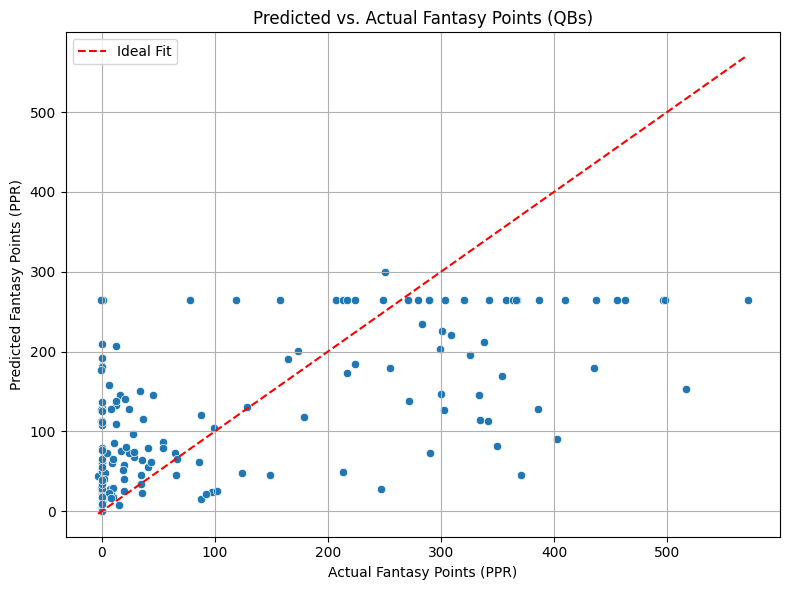

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot predicted vs. actual fantasy points
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Fantasy Points (PPR)")
plt.ylabel("Predicted Fantasy Points (PPR)")
plt.title("Predicted vs. Actual Fantasy Points (QBs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot Feature Importance

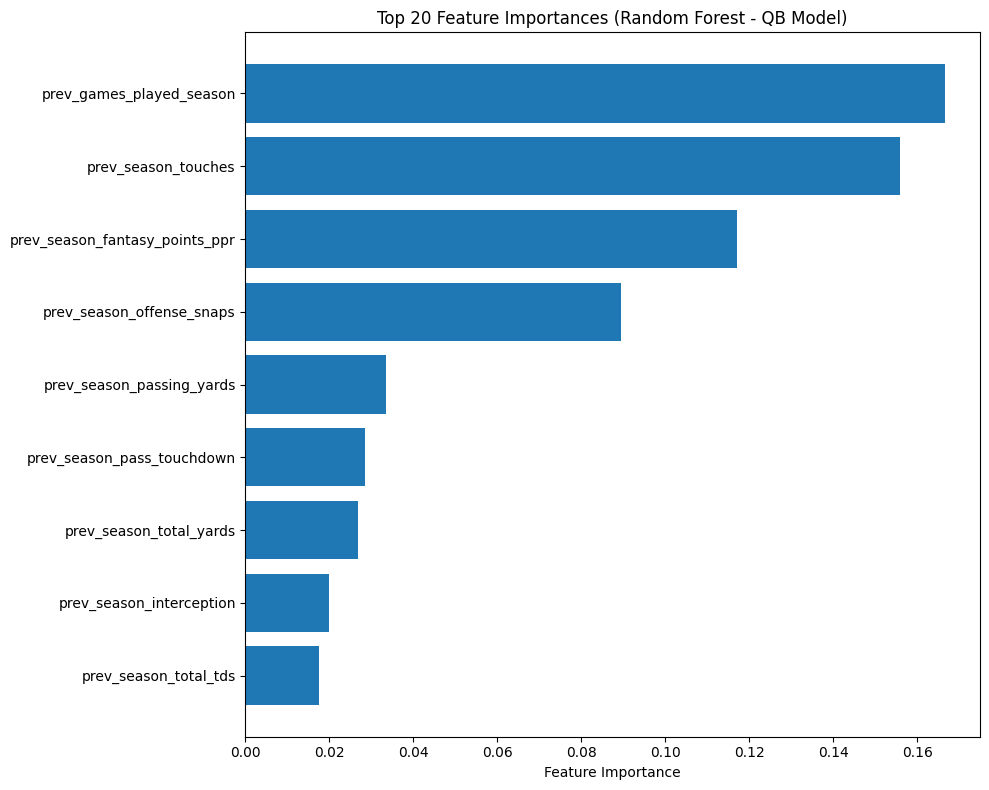

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # Top 20 features
top_features = qb_features_df.columns[indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest - QB Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Running Backs (RB)

## Feature Engineering

In [37]:
# Filter for RBs only and sort for lag feature creation
rb_df = df[df['position'] == 'RB'].copy().sort_values(by=['player_id', 'season'])

# Identify numeric season-level columns for lagging
season_cols = [col for col in rb_df.columns if col.startswith("season_") and pd.api.types.is_numeric_dtype(rb_df[col])]
lagged_cols = {col: f"prev_{col}" for col in season_cols}

# Create lag features from prior season stats
rb_df = rb_df.groupby('player_id').apply(lambda group: group.assign(**{
    new_col: group[old_col].shift(1) for old_col, new_col in lagged_cols.items()
})).reset_index(drop=True)

# Add domain-relevant RB metrics
extra_features_rb = [
    'games_played_season',
    'season_rushing_yards',
    'season_rush_touchdown',
    'season_receptions',
    'season_receiving_yards',
    'season_receiving_touchdown',
    'season_total_tds',
    'season_touches',
    'season_total_yards',
    'season_offense_snaps'
]

for col in extra_features_rb:
    rb_df[f'prev_{col}'] = rb_df.groupby('player_id')[col].shift(1)

# Drop rows with missing target or features
required_cols_rb = ['season_fantasy_points_ppr'] + [f'prev_{col}' for col in extra_features_rb]
rb_df_filtered = rb_df.dropna(subset=required_cols_rb)

# Prepare final features and target
base_lagged_features_rb = [col for col in rb_df_filtered.columns if col.startswith("prev_season_") and pd.api.types.is_numeric_dtype(rb_df_filtered[col])]
final_feature_cols_rb = base_lagged_features_rb + [f'prev_{col}' for col in extra_features_rb]


/var/folders/tx/bg_9dv292q3ct7x5bj7l118h0000gn/T/ipykernel_99466/2562038671.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rb_df = rb_df.groupby('player_id').apply(lambda group: group.assign(**{


## Model Building

In [38]:
rb_features_df = rb_df_filtered[final_feature_cols_rb]
rb_target_df = rb_df_filtered['season_fantasy_points_ppr']

# Train/test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(
    rb_features_df, rb_target_df, test_size=0.2, random_state=42
)

# Train the model
rf_model_rb = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model_rb.fit(X_train_rb, y_train_rb)

# Predict and evaluate
y_pred_rb = rf_model_rb.predict(X_test_rb)
mae_rb = mean_absolute_error(y_test_rb, y_pred_rb)
r2_rb = r2_score(y_test_rb, y_pred_rb)

(mae_rb, r2_rb)

(np.float64(54.41739277096581), 0.26349486075751327)

## Plot Accuracy

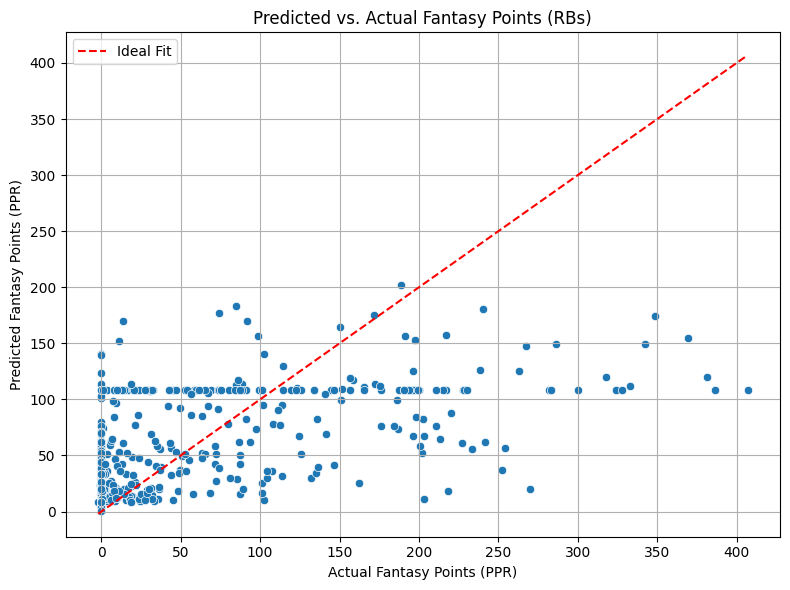

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot predicted vs. actual for RBs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_rb, y=y_pred_rb)
plt.plot([y_test_rb.min(), y_test_rb.max()], [y_test_rb.min(), y_test_rb.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Fantasy Points (PPR)")
plt.ylabel("Predicted Fantasy Points (PPR)")
plt.title("Predicted vs. Actual Fantasy Points (RBs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot Feature Importance

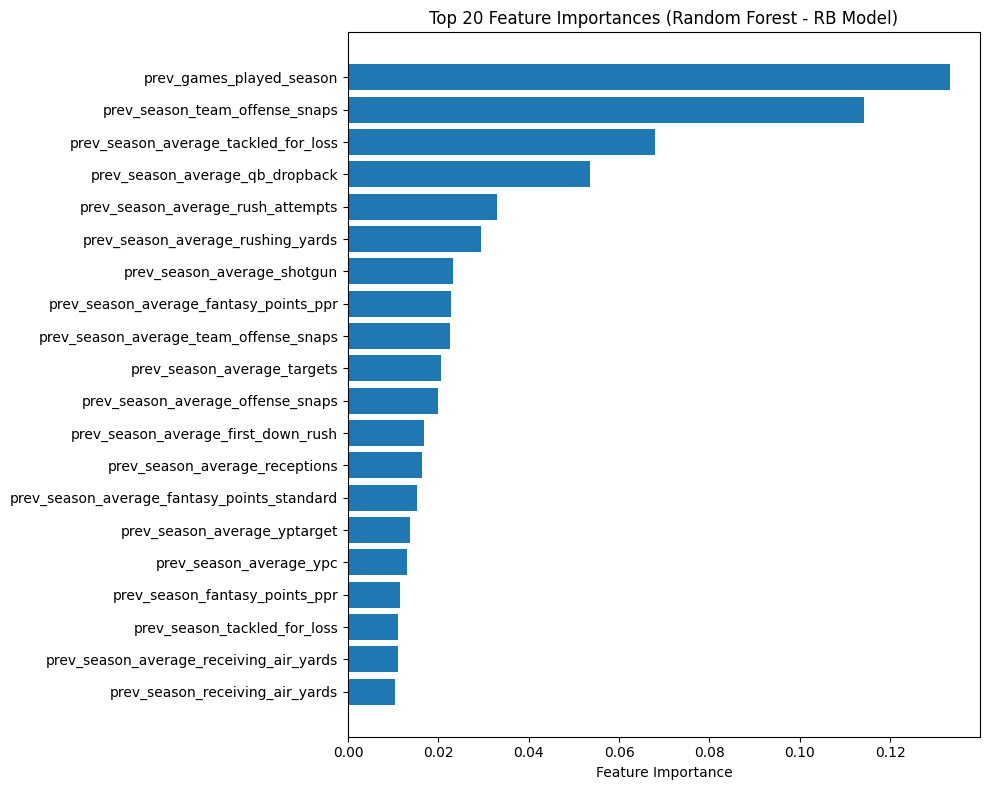

In [40]:
# Get feature importances from the RB Random Forest model
importances_rb = rf_model_rb.feature_importances_
indices_rb = np.argsort(importances_rb)[-20:][::-1]  # Top 20
top_features_rb = rb_features_df.columns[indices_rb]
top_importances_rb = importances_rb[indices_rb]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features_rb, top_importances_rb)
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest - RB Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Wide Receivers and Tight Ends (WR/TE)

## Feature Engineering

In [42]:
# Filter for WR and TE positions
wrte_df = df[df['position'].isin(['WR', 'TE'])].copy().sort_values(by=['player_id', 'season'])

# Create lag features for numeric "season_" columns
season_cols = [col for col in wrte_df.columns if col.startswith("season_") and pd.api.types.is_numeric_dtype(wrte_df[col])]
lagged_cols = {col: f"prev_{col}" for col in season_cols}

wrte_df = wrte_df.groupby('player_id').apply(lambda group: group.assign(**{
    new_col: group[old_col].shift(1) for old_col, new_col in lagged_cols.items()
})).reset_index(drop=True)

# Add WR/TE-specific lagged features
extra_features_wrte = [
    'games_played_season',
    'season_receptions',
    'season_receiving_yards',
    'season_receiving_touchdown',
    'season_targets',
    'season_total_tds',
    'season_touches',
    'season_total_yards',
    'season_offense_snaps'
]

for col in extra_features_wrte:
    wrte_df[f'prev_{col}'] = wrte_df.groupby('player_id')[col].shift(1)

# Drop rows with missing target or features
required_cols_wrte = ['season_fantasy_points_ppr'] + [f'prev_{col}' for col in extra_features_wrte]
wrte_df_filtered = wrte_df.dropna(subset=required_cols_wrte)

# Prepare final features and target
base_lagged_features_wrte = [col for col in wrte_df_filtered.columns if col.startswith("prev_season_") and pd.api.types.is_numeric_dtype(wrte_df_filtered[col])]
final_feature_cols_wrte = base_lagged_features_wrte + [f'prev_{col}' for col in extra_features_wrte]

wrte_features_df = wrte_df_filtered[final_feature_cols_wrte]
wrte_target_df = wrte_df_filtered['season_fantasy_points_ppr']

/var/folders/tx/bg_9dv292q3ct7x5bj7l118h0000gn/T/ipykernel_99466/3742576522.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wrte_df = wrte_df.groupby('player_id').apply(lambda group: group.assign(**{


## Model Building 

In [43]:
# Train/test split and model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X_train_wrte, X_test_wrte, y_train_wrte, y_test_wrte = train_test_split(
    wrte_features_df, wrte_target_df, test_size=0.2, random_state=42
)

rf_model_wrte = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model_wrte.fit(X_train_wrte, y_train_wrte)

# Predict and evaluate
y_pred_wrte = rf_model_wrte.predict(X_test_wrte)
mae_wrte = mean_absolute_error(y_test_wrte, y_pred_wrte)
r2_wrte = r2_score(y_test_wrte, y_pred_wrte)

(mae_wrte, r2_wrte)

(np.float64(44.750347125015), 0.35680786103565565)

# Plot Accuracy

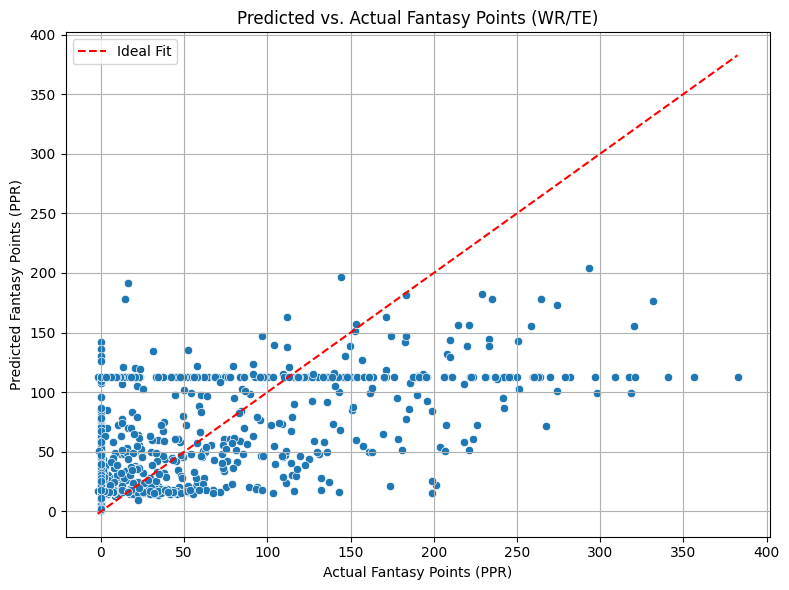

In [44]:
# Plot predicted vs. actual for WR/TE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_wrte, y=y_pred_wrte)
plt.plot([y_test_wrte.min(), y_test_wrte.max()], [y_test_wrte.min(), y_test_wrte.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Fantasy Points (PPR)")
plt.ylabel("Predicted Fantasy Points (PPR)")
plt.title("Predicted vs. Actual Fantasy Points (WR/TE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


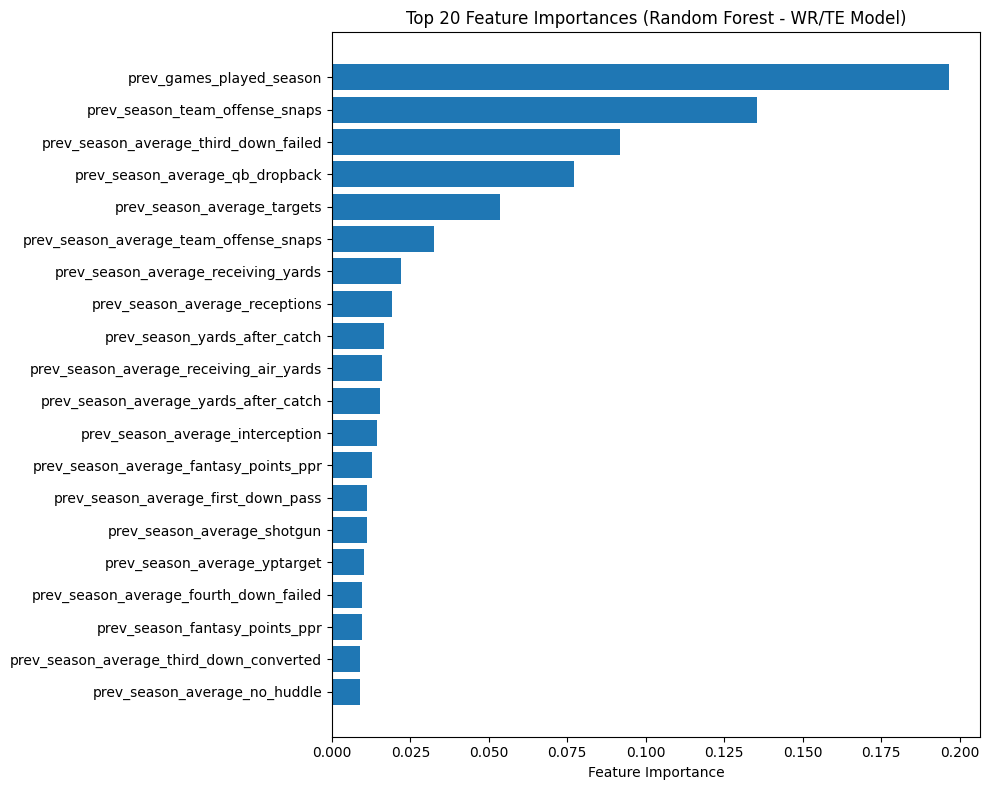

In [45]:
# Get feature importances from the WR/TE Random Forest model
importances_wrte = rf_model_wrte.feature_importances_
indices_wrte = np.argsort(importances_wrte)[-20:][::-1]  # Top 20
top_features_wrte = wrte_features_df.columns[indices_wrte]
top_importances_wrte = importances_wrte[indices_wrte]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features_wrte, top_importances_wrte)
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest - WR/TE Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
